<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [10]</a>'.</span>

# STEP 1: Imports and Get Data

In [1]:
from model_components.data_reader import FinancialTimeSeriesDataset
from model_components.transformers import TimeSeriesTransformer
from model_components.fin_trainer import TimeSeriesForecastingTrainer
from model_components.utils import (
    create_optimizer,
    create_scheduler,
    plot_lr_schedule
)
  
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import tarfile
import shutil
import wandb
import yaml
from sklearn.preprocessing import MinMaxScaler, StandardScaler
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [2]:
%%writefile config.yaml

Name                      : "Nayesha-Gopal"

###### Dataset -----------------------------------------------------------------
data:                    # Currently setup for Colab assuming out setup
  root                 : "/local/hw4_data/hw4p1_data"  # TODO: Set the root path of your data
  train_partition      : "train"  # train
  val_partition        : "val"    # val
  test_partition       : "test"   # test
  subset               : 1.0      # Load a subset of the data (for debugging, testing, etc
  batch_size           : 256      #
  NUM_WORKERS          : 2        # Set to 0 for CPU
  forecast_horizon     : 5

###### Network Specs -------------------------------------------------------------
model: # Decoder-Only Language Model (HW4P1)
  d_model                   : 256
  d_ff                      : 1024
  d_freq                    : 3    #how many dimensions to split time into- must be odd because it adds 1?
  num_layers                : 2
  num_heads                 : 2
  dropout                   : 0.0

###### Common Training Parameters ------------------------------------------------
training:
  use_wandb                   : True   # Toggle wandb logging
  wandb_run_id                : "none" # "none" or "run_id"
  resume                      : False  # Resume an existing run (run_id != 'none')
  epochs                      : 10
  gradient_accumulation_steps : 1
  wandb_project               : "IDL_final project PegasusNG" # wandb project to log to

###### Loss ----------------------------------------------------------------------
loss: # Just good ol' MSE
  label_smoothing: 0.0

###### Optimizer -----------------------------------------------------------------
optimizer:
  name: "adamw" # Options: sgd, adam, adamw
  lr: 5.0e-4   # Base learning rate

  # Common parameters
  weight_decay: 0.0001

  # Parameter groups
  param_groups:
    - name: self_attn
      patterns: []  # Will match all parameters containing keywords set their learning rate to 0.0001
      lr: 0.0001    # LR for self_attn
      layer_decay:
        enabled: False
        decay_rate: 0.8

    - name: ffn
      patterns: [] # Will match all parameters containing "ffn" and set their learning rate to 0.0001
      lr: 0.0001   # LR for ffn
      layer_decay:
        enabled: False
        decay_rate: 0.8

  # Layer-wise learning rates
  layer_decay:
    enabled: False
    decay_rate: 0.75

  # SGD specific parameters
  sgd:
    momentum: 0.9
    nesterov: True
    dampening: 0

  # Adam specific parameters
  adam:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

  # AdamW specific parameters
  adamw:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

###### Scheduler -----------------------------------------------------------------
scheduler:
  name: "cosine"  # Options: reduce_lr, cosine, cosine_warm

  # ReduceLROnPlateau specific parameters
  reduce_lr:
    mode: "min"  # Options: min, max
    factor: 0.1  # Factor to reduce learning rate by
    patience: 10  # Number of epochs with no improvement after which LR will be reduced
    threshold: 0.0001  # Threshold for measuring the new optimum
    threshold_mode: "rel"  # Options: rel, abs
    cooldown: 0  # Number of epochs to wait before resuming normal operation
    min_lr: 0.0000001  # Minimum learning rate
    eps: 1.0e-8  # Minimal decay applied to lr

  # CosineAnnealingLR specific parameters
  cosine:
    T_max: 15  # Maximum number of iterations
    eta_min: 1.0e-8  # Minimum learning rate
    last_epoch: -1

  # CosineAnnealingWarmRestarts specific parameters
  cosine_warm:
    T_0: 4  # Number of iterations for the first restart
    T_mult: 4  # Factor increasing T_i after each restart
    eta_min: 0.0000001  # Minimum learning rate
    last_epoch: -1

  # Warmup parameters (can be used with any scheduler)
  warmup:
    enabled: True
    type: "exponential"  # Options: linear, exponential
    epochs: 5
    start_factor: 0.1
    end_factor: 1.0

Overwriting config.yaml


In [3]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [4]:
# CREATE DATASETS
train_dataset = FinancialTimeSeriesDataset(
    tickers=['^SPX'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=30,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='zscore',
    split='train',
    val_ratio=0.25,
    fit_scaler=True
)
scaler = train_dataset.scaler

val_dataset = FinancialTimeSeriesDataset(
    tickers=['^SPX'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=30,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='zscore',
    split='val',
    val_ratio=0.25,
    scaler=scaler
)




YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Processing ^SPX (train):   0%|                                                                         | 0/926 [00:00<?, ?it/s]

Processing ^SPX (train):   0%|                                                                 | 1/926 [00:00<03:56,  3.91it/s]

Processing ^SPX (train):   0%|▏                                                                | 2/926 [00:00<06:08,  2.51it/s]

Processing ^SPX (train):   0%|▏                                                                | 3/926 [00:01<06:16,  2.45it/s]

Processing ^SPX (train):   0%|▎                                                                | 4/926 [00:01<05:26,  2.82it/s]

Processing ^SPX (train):   1%|▎                                                                | 5/926 [00:01<06:05,  2.52it/s]

Processing ^SPX (train):   1%|▍                                                                | 6/926 [00:02<05:44,  2.67it/s]

Processing ^SPX (train):   1%|▍                                                                | 7/926 [00:02<05:50,  2.62it/s]

Processing ^SPX (train):   1%|▌                                                                | 8/926 [00:02<05:17,  2.89it/s]

Processing ^SPX (train):   1%|▋                                                                | 9/926 [00:03<05:27,  2.80it/s]

Processing ^SPX (train):   1%|▋                                                               | 10/926 [00:03<05:28,  2.78it/s]

Processing ^SPX (train):   1%|▊                                                               | 11/926 [00:04<05:38,  2.70it/s]

Processing ^SPX (train):   1%|▊                                                               | 12/926 [00:04<05:47,  2.63it/s]

Processing ^SPX (train):   1%|▉                                                               | 13/926 [00:04<05:48,  2.62it/s]

Processing ^SPX (train):   2%|▉                                                               | 14/926 [00:05<05:25,  2.80it/s]

Processing ^SPX (train):   2%|█                                                               | 15/926 [00:05<05:34,  2.72it/s]

Processing ^SPX (train):   2%|█                                                               | 16/926 [00:05<05:35,  2.71it/s]

Processing ^SPX (train):   2%|█▏                                                              | 17/926 [00:06<05:10,  2.93it/s]

Processing ^SPX (train):   2%|█▏                                                              | 18/926 [00:06<04:59,  3.03it/s]

Processing ^SPX (train):   2%|█▎                                                              | 19/926 [00:06<05:04,  2.98it/s]

Processing ^SPX (train):   2%|█▍                                                              | 20/926 [00:07<05:37,  2.68it/s]

Processing ^SPX (train):   2%|█▍                                                              | 21/926 [00:07<05:34,  2.70it/s]

Processing ^SPX (train):   2%|█▌                                                              | 22/926 [00:08<05:52,  2.56it/s]

Processing ^SPX (train):   2%|█▌                                                              | 23/926 [00:08<06:01,  2.50it/s]

Processing ^SPX (train):   3%|█▋                                                              | 24/926 [00:08<05:23,  2.78it/s]

Processing ^SPX (train):   3%|█▋                                                              | 25/926 [00:09<05:42,  2.63it/s]

Processing ^SPX (train):   3%|█▊                                                              | 26/926 [00:09<05:31,  2.72it/s]

Processing ^SPX (train):   3%|█▊                                                              | 27/926 [00:09<05:12,  2.87it/s]

Processing ^SPX (train):   3%|█▉                                                              | 28/926 [00:10<05:20,  2.81it/s]

Processing ^SPX (train):   3%|██                                                              | 29/926 [00:10<05:01,  2.98it/s]

Processing ^SPX (train):   3%|██                                                              | 30/926 [00:10<05:08,  2.91it/s]

Processing ^SPX (train):   3%|██▏                                                             | 31/926 [00:11<05:19,  2.80it/s]

Processing ^SPX (train):   3%|██▏                                                             | 32/926 [00:11<05:09,  2.89it/s]

Processing ^SPX (train):   4%|██▎                                                             | 33/926 [00:11<04:55,  3.02it/s]

Processing ^SPX (train):   4%|██▎                                                             | 34/926 [00:12<04:52,  3.05it/s]

Processing ^SPX (train):   4%|██▍                                                             | 35/926 [00:12<05:26,  2.72it/s]

Processing ^SPX (train):   4%|██▍                                                             | 36/926 [00:13<05:46,  2.57it/s]

Processing ^SPX (train):   4%|██▌                                                             | 37/926 [00:13<05:54,  2.51it/s]

Processing ^SPX (train):   4%|██▋                                                             | 38/926 [00:13<05:33,  2.66it/s]

Processing ^SPX (train):   4%|██▋                                                             | 39/926 [00:14<05:16,  2.80it/s]

Processing ^SPX (train):   4%|██▊                                                             | 40/926 [00:14<05:30,  2.68it/s]

Processing ^SPX (train):   4%|██▊                                                             | 41/926 [00:14<05:33,  2.66it/s]

Processing ^SPX (train):   5%|██▉                                                             | 42/926 [00:15<05:13,  2.82it/s]

Processing ^SPX (train):   5%|██▉                                                             | 43/926 [00:15<05:38,  2.61it/s]

Processing ^SPX (train):   5%|███                                                             | 44/926 [00:16<05:33,  2.64it/s]

Processing ^SPX (train):   5%|███                                                             | 45/926 [00:16<05:02,  2.91it/s]

Processing ^SPX (train):   5%|███▏                                                            | 46/926 [00:16<05:33,  2.64it/s]

Processing ^SPX (train):   5%|███▏                                                            | 47/926 [00:17<05:36,  2.61it/s]

Processing ^SPX (train):   5%|███▎                                                            | 48/926 [00:17<05:52,  2.49it/s]

Processing ^SPX (train):   5%|███▍                                                            | 49/926 [00:18<05:43,  2.55it/s]

Processing ^SPX (train):   5%|███▍                                                            | 50/926 [00:18<05:20,  2.73it/s]

Processing ^SPX (train):   6%|███▌                                                            | 51/926 [00:18<05:29,  2.65it/s]

Processing ^SPX (train):   6%|███▌                                                            | 52/926 [00:19<05:43,  2.55it/s]

Processing ^SPX (train):   6%|███▋                                                            | 53/926 [00:19<05:30,  2.64it/s]

Processing ^SPX (train):   6%|███▋                                                            | 54/926 [00:19<05:09,  2.81it/s]

Processing ^SPX (train):   6%|███▊                                                            | 55/926 [00:20<04:57,  2.93it/s]

Processing ^SPX (train):   6%|███▊                                                            | 56/926 [00:20<05:08,  2.82it/s]

Processing ^SPX (train):   6%|███▉                                                            | 57/926 [00:20<05:21,  2.70it/s]

Processing ^SPX (train):   6%|████                                                            | 58/926 [00:21<05:39,  2.55it/s]

Processing ^SPX (train):   6%|████                                                            | 59/926 [00:21<05:21,  2.69it/s]

Processing ^SPX (train):   6%|████▏                                                           | 60/926 [00:22<05:28,  2.64it/s]

Processing ^SPX (train):   7%|████▏                                                           | 61/926 [00:22<05:47,  2.49it/s]

Processing ^SPX (train):   7%|████▎                                                           | 62/926 [00:22<06:00,  2.40it/s]

Processing ^SPX (train):   7%|████▎                                                           | 63/926 [00:23<05:27,  2.63it/s]

Processing ^SPX (train):   7%|████▍                                                           | 64/926 [00:23<05:38,  2.55it/s]

Processing ^SPX (train):   7%|████▍                                                           | 65/926 [00:23<05:08,  2.79it/s]

Processing ^SPX (train):   7%|████▌                                                           | 66/926 [00:24<05:10,  2.77it/s]

Processing ^SPX (train):   7%|████▋                                                           | 67/926 [00:24<05:18,  2.70it/s]

Processing ^SPX (train):   7%|████▋                                                           | 68/926 [00:25<05:39,  2.53it/s]

Processing ^SPX (train):   7%|████▊                                                           | 69/926 [00:25<05:44,  2.49it/s]

Processing ^SPX (train):   8%|████▊                                                           | 70/926 [00:25<05:23,  2.65it/s]

Processing ^SPX (train):   8%|████▉                                                           | 71/926 [00:26<05:48,  2.46it/s]

Processing ^SPX (train):   8%|████▉                                                           | 72/926 [00:26<05:25,  2.62it/s]

Processing ^SPX (train):   8%|█████                                                           | 73/926 [00:27<04:58,  2.85it/s]

Processing ^SPX (train):   8%|█████                                                           | 74/926 [00:27<05:18,  2.68it/s]

Processing ^SPX (train):   8%|█████▏                                                          | 75/926 [00:27<05:43,  2.48it/s]

Processing ^SPX (train):   8%|█████▎                                                          | 76/926 [00:28<05:48,  2.44it/s]

Processing ^SPX (train):   8%|█████▎                                                          | 77/926 [00:28<05:38,  2.51it/s]

Processing ^SPX (train):   8%|█████▍                                                          | 78/926 [00:29<05:49,  2.42it/s]

Processing ^SPX (train):   9%|█████▍                                                          | 79/926 [00:29<05:23,  2.62it/s]

Processing ^SPX (train):   9%|█████▌                                                          | 80/926 [00:29<05:38,  2.50it/s]

Processing ^SPX (train):   9%|█████▌                                                          | 81/926 [00:30<05:01,  2.80it/s]

Processing ^SPX (train):   9%|█████▋                                                          | 82/926 [00:30<05:34,  2.53it/s]

Processing ^SPX (train):   9%|█████▋                                                          | 83/926 [00:31<05:41,  2.47it/s]

Processing ^SPX (train):   9%|█████▊                                                          | 84/926 [00:31<05:55,  2.37it/s]

Processing ^SPX (train):   9%|█████▊                                                          | 85/926 [00:31<05:44,  2.44it/s]

Processing ^SPX (train):   9%|█████▉                                                          | 86/926 [00:32<05:15,  2.66it/s]

Processing ^SPX (train):   9%|██████                                                          | 87/926 [00:32<05:31,  2.53it/s]

Processing ^SPX (train):  10%|██████                                                          | 88/926 [00:33<05:32,  2.52it/s]

Processing ^SPX (train):  10%|██████▏                                                         | 89/926 [00:33<04:58,  2.80it/s]

Processing ^SPX (train):  10%|██████▏                                                         | 90/926 [00:33<05:07,  2.72it/s]

Processing ^SPX (train):  10%|██████▎                                                         | 91/926 [00:33<04:21,  3.20it/s]

Processing ^SPX (train):  10%|██████▎                                                         | 92/926 [00:34<04:40,  2.97it/s]

Processing ^SPX (train):  10%|██████▍                                                         | 93/926 [00:34<04:37,  3.00it/s]

Processing ^SPX (train):  10%|██████▍                                                         | 94/926 [00:35<05:19,  2.61it/s]

Processing ^SPX (train):  10%|██████▌                                                         | 95/926 [00:35<05:19,  2.60it/s]

Processing ^SPX (train):  10%|██████▋                                                         | 96/926 [00:35<05:35,  2.48it/s]

Processing ^SPX (train):  10%|██████▋                                                         | 97/926 [00:36<05:30,  2.51it/s]

Processing ^SPX (train):  11%|██████▊                                                         | 98/926 [00:36<05:14,  2.63it/s]

Processing ^SPX (train):  11%|██████▊                                                         | 99/926 [00:37<05:07,  2.69it/s]

Processing ^SPX (train):  11%|██████▊                                                        | 100/926 [00:37<05:10,  2.66it/s]

Processing ^SPX (train):  11%|██████▊                                                        | 101/926 [00:37<04:33,  3.01it/s]

Processing ^SPX (train):  11%|██████▉                                                        | 102/926 [00:37<04:27,  3.08it/s]

Processing ^SPX (train):  11%|███████                                                        | 103/926 [00:38<04:39,  2.94it/s]

Processing ^SPX (train):  11%|███████                                                        | 104/926 [00:38<04:46,  2.87it/s]

Processing ^SPX (train):  11%|███████▏                                                       | 105/926 [00:39<05:13,  2.62it/s]

Processing ^SPX (train):  11%|███████▏                                                       | 106/926 [00:39<04:41,  2.91it/s]

Processing ^SPX (train):  12%|███████▎                                                       | 107/926 [00:39<04:48,  2.83it/s]

Processing ^SPX (train):  12%|███████▎                                                       | 108/926 [00:40<04:43,  2.88it/s]

Processing ^SPX (train):  12%|███████▍                                                       | 109/926 [00:40<05:09,  2.64it/s]

Processing ^SPX (train):  12%|███████▍                                                       | 110/926 [00:41<05:18,  2.57it/s]

Processing ^SPX (train):  12%|███████▌                                                       | 111/926 [00:41<04:59,  2.72it/s]

Processing ^SPX (train):  12%|███████▌                                                       | 112/926 [00:41<04:45,  2.85it/s]

Processing ^SPX (train):  12%|███████▋                                                       | 113/926 [00:41<04:30,  3.01it/s]

Processing ^SPX (train):  12%|███████▊                                                       | 114/926 [00:42<05:13,  2.59it/s]

Processing ^SPX (train):  12%|███████▊                                                       | 115/926 [00:42<04:58,  2.72it/s]

Processing ^SPX (train):  13%|███████▉                                                       | 116/926 [00:43<04:57,  2.73it/s]

Processing ^SPX (train):  13%|███████▉                                                       | 117/926 [00:43<05:12,  2.59it/s]

Processing ^SPX (train):  13%|████████                                                       | 118/926 [00:43<05:19,  2.53it/s]

Processing ^SPX (train):  13%|████████                                                       | 119/926 [00:44<05:16,  2.55it/s]

Processing ^SPX (train):  13%|████████▏                                                      | 120/926 [00:44<04:50,  2.77it/s]

Processing ^SPX (train):  13%|████████▏                                                      | 121/926 [00:44<04:50,  2.77it/s]

Processing ^SPX (train):  13%|████████▎                                                      | 122/926 [00:45<05:15,  2.55it/s]

Processing ^SPX (train):  13%|████████▎                                                      | 123/926 [00:45<04:50,  2.76it/s]

Processing ^SPX (train):  13%|████████▍                                                      | 124/926 [00:46<04:43,  2.83it/s]

Processing ^SPX (train):  13%|████████▌                                                      | 125/926 [00:46<04:24,  3.03it/s]

Processing ^SPX (train):  14%|████████▌                                                      | 126/926 [00:46<04:03,  3.29it/s]

Processing ^SPX (train):  14%|████████▋                                                      | 127/926 [00:46<04:16,  3.11it/s]

Processing ^SPX (train):  14%|████████▋                                                      | 128/926 [00:47<04:49,  2.75it/s]

Processing ^SPX (train):  14%|████████▊                                                      | 129/926 [00:47<04:27,  2.98it/s]

Processing ^SPX (train):  14%|████████▊                                                      | 130/926 [00:48<04:50,  2.74it/s]

Processing ^SPX (train):  14%|████████▉                                                      | 131/926 [00:48<04:32,  2.91it/s]

Processing ^SPX (train):  14%|████████▉                                                      | 132/926 [00:48<04:10,  3.17it/s]

Processing ^SPX (train):  14%|█████████                                                      | 133/926 [00:48<04:09,  3.17it/s]

Processing ^SPX (train):  14%|█████████                                                      | 134/926 [00:49<04:28,  2.95it/s]

Processing ^SPX (train):  15%|█████████▏                                                     | 135/926 [00:49<04:12,  3.13it/s]

Processing ^SPX (train):  15%|█████████▎                                                     | 136/926 [00:49<03:59,  3.30it/s]

Processing ^SPX (train):  15%|█████████▎                                                     | 137/926 [00:50<04:27,  2.95it/s]

Processing ^SPX (train):  15%|█████████▍                                                     | 138/926 [00:50<04:42,  2.79it/s]

Processing ^SPX (train):  15%|█████████▍                                                     | 139/926 [00:51<04:39,  2.82it/s]

Processing ^SPX (train):  15%|█████████▌                                                     | 140/926 [00:51<04:46,  2.74it/s]

Processing ^SPX (train):  15%|█████████▌                                                     | 141/926 [00:51<05:10,  2.53it/s]

Processing ^SPX (train):  15%|█████████▋                                                     | 142/926 [00:52<04:47,  2.73it/s]

Processing ^SPX (train):  15%|█████████▋                                                     | 143/926 [00:52<05:14,  2.49it/s]

Processing ^SPX (train):  16%|█████████▊                                                     | 144/926 [00:53<04:47,  2.72it/s]

Processing ^SPX (train):  16%|█████████▊                                                     | 145/926 [00:53<05:20,  2.44it/s]

Processing ^SPX (train):  16%|█████████▉                                                     | 146/926 [00:53<04:58,  2.62it/s]

Processing ^SPX (train):  16%|██████████                                                     | 147/926 [00:54<04:40,  2.77it/s]

Processing ^SPX (train):  16%|██████████                                                     | 148/926 [00:54<04:40,  2.77it/s]

Processing ^SPX (train):  16%|██████████▏                                                    | 149/926 [00:54<04:25,  2.93it/s]

Processing ^SPX (train):  16%|██████████▏                                                    | 150/926 [00:55<04:16,  3.02it/s]

Processing ^SPX (train):  16%|██████████▎                                                    | 151/926 [00:55<04:35,  2.82it/s]

Processing ^SPX (train):  16%|██████████▎                                                    | 152/926 [00:55<04:25,  2.91it/s]

Processing ^SPX (train):  17%|██████████▍                                                    | 153/926 [00:56<04:31,  2.85it/s]

Processing ^SPX (train):  17%|██████████▍                                                    | 154/926 [00:56<04:29,  2.86it/s]

Processing ^SPX (train):  17%|██████████▌                                                    | 155/926 [00:56<04:42,  2.73it/s]

Processing ^SPX (train):  17%|██████████▌                                                    | 156/926 [00:57<04:51,  2.64it/s]

Processing ^SPX (train):  17%|██████████▋                                                    | 157/926 [00:57<04:51,  2.63it/s]

Processing ^SPX (train):  17%|██████████▋                                                    | 158/926 [00:58<04:39,  2.74it/s]

Processing ^SPX (train):  17%|██████████▊                                                    | 159/926 [00:58<04:25,  2.89it/s]

Processing ^SPX (train):  17%|██████████▉                                                    | 160/926 [00:58<05:02,  2.53it/s]

Processing ^SPX (train):  17%|██████████▉                                                    | 161/926 [00:59<04:43,  2.70it/s]

Processing ^SPX (train):  17%|███████████                                                    | 162/926 [00:59<05:05,  2.50it/s]

Processing ^SPX (train):  18%|███████████                                                    | 163/926 [01:00<05:13,  2.43it/s]

Processing ^SPX (train):  18%|███████████▏                                                   | 164/926 [01:00<04:56,  2.57it/s]

Processing ^SPX (train):  18%|███████████▏                                                   | 165/926 [01:00<04:49,  2.63it/s]

Processing ^SPX (train):  18%|███████████▎                                                   | 166/926 [01:01<05:07,  2.47it/s]

Processing ^SPX (train):  18%|███████████▎                                                   | 167/926 [01:01<05:00,  2.52it/s]

Processing ^SPX (train):  18%|███████████▍                                                   | 168/926 [01:02<04:45,  2.65it/s]

Processing ^SPX (train):  18%|███████████▍                                                   | 169/926 [01:02<05:15,  2.40it/s]

Processing ^SPX (train):  18%|███████████▌                                                   | 170/926 [01:02<04:53,  2.58it/s]

Processing ^SPX (train):  18%|███████████▋                                                   | 171/926 [01:03<05:03,  2.49it/s]

Processing ^SPX (train):  19%|███████████▋                                                   | 172/926 [01:03<04:32,  2.77it/s]

Processing ^SPX (train):  19%|███████████▊                                                   | 173/926 [01:03<04:54,  2.56it/s]

Processing ^SPX (train):  19%|███████████▊                                                   | 174/926 [01:04<04:56,  2.54it/s]

Processing ^SPX (train):  19%|███████████▉                                                   | 175/926 [01:04<04:42,  2.66it/s]

Processing ^SPX (train):  19%|███████████▉                                                   | 176/926 [01:05<04:25,  2.82it/s]

Processing ^SPX (train):  19%|████████████                                                   | 177/926 [01:05<04:29,  2.78it/s]

Processing ^SPX (train):  19%|████████████                                                   | 178/926 [01:05<04:27,  2.79it/s]

Processing ^SPX (train):  19%|████████████▏                                                  | 179/926 [01:06<05:00,  2.48it/s]

Processing ^SPX (train):  19%|████████████▏                                                  | 180/926 [01:06<04:49,  2.57it/s]

Processing ^SPX (train):  20%|████████████▎                                                  | 181/926 [01:07<04:56,  2.51it/s]

Processing ^SPX (train):  20%|████████████▍                                                  | 182/926 [01:07<04:52,  2.55it/s]

Processing ^SPX (train):  20%|████████████▍                                                  | 183/926 [01:07<04:30,  2.75it/s]

Processing ^SPX (train):  20%|████████████▌                                                  | 184/926 [01:08<04:25,  2.79it/s]

Processing ^SPX (train):  20%|████████████▌                                                  | 185/926 [01:08<04:09,  2.97it/s]

Processing ^SPX (train):  20%|████████████▋                                                  | 186/926 [01:08<04:13,  2.92it/s]

Processing ^SPX (train):  20%|████████████▋                                                  | 187/926 [01:09<04:33,  2.70it/s]

Processing ^SPX (train):  20%|████████████▊                                                  | 188/926 [01:09<04:20,  2.83it/s]

Processing ^SPX (train):  20%|████████████▊                                                  | 189/926 [01:09<04:07,  2.98it/s]

Processing ^SPX (train):  21%|████████████▉                                                  | 190/926 [01:10<04:25,  2.77it/s]

Processing ^SPX (train):  21%|████████████▉                                                  | 191/926 [01:10<04:39,  2.63it/s]

Processing ^SPX (train):  21%|█████████████                                                  | 192/926 [01:11<04:50,  2.53it/s]

Processing ^SPX (train):  21%|█████████████▏                                                 | 193/926 [01:11<04:53,  2.50it/s]

Processing ^SPX (train):  21%|█████████████▏                                                 | 194/926 [01:11<05:06,  2.39it/s]

Processing ^SPX (train):  21%|█████████████▎                                                 | 195/926 [01:12<05:33,  2.19it/s]

Processing ^SPX (train):  21%|█████████████▎                                                 | 196/926 [01:12<05:15,  2.31it/s]

Processing ^SPX (train):  21%|█████████████▍                                                 | 197/926 [01:13<05:12,  2.33it/s]

Processing ^SPX (train):  21%|█████████████▍                                                 | 198/926 [01:13<04:53,  2.48it/s]

Processing ^SPX (train):  21%|█████████████▌                                                 | 199/926 [01:13<04:25,  2.74it/s]

Processing ^SPX (train):  22%|█████████████▌                                                 | 200/926 [01:14<04:06,  2.95it/s]

Processing ^SPX (train):  22%|█████████████▋                                                 | 201/926 [01:14<04:30,  2.68it/s]

Processing ^SPX (train):  22%|█████████████▋                                                 | 202/926 [01:15<04:44,  2.54it/s]

Processing ^SPX (train):  22%|█████████████▊                                                 | 203/926 [01:15<04:56,  2.43it/s]

Processing ^SPX (train):  22%|█████████████▉                                                 | 204/926 [01:15<04:39,  2.59it/s]

Processing ^SPX (train):  22%|█████████████▉                                                 | 205/926 [01:16<04:31,  2.66it/s]

Processing ^SPX (train):  22%|██████████████                                                 | 206/926 [01:16<05:24,  2.22it/s]

Processing ^SPX (train):  22%|██████████████                                                 | 207/926 [01:17<05:22,  2.23it/s]

Processing ^SPX (train):  22%|██████████████▏                                                | 208/926 [01:17<05:02,  2.37it/s]

Processing ^SPX (train):  23%|██████████████▏                                                | 209/926 [01:17<04:35,  2.61it/s]

Processing ^SPX (train):  23%|██████████████▎                                                | 210/926 [01:18<05:19,  2.24it/s]

Processing ^SPX (train):  23%|██████████████▎                                                | 211/926 [01:18<05:25,  2.20it/s]

Processing ^SPX (train):  23%|██████████████▍                                                | 212/926 [01:19<05:05,  2.34it/s]

Processing ^SPX (train):  23%|██████████████▍                                                | 213/926 [01:19<04:59,  2.38it/s]

Processing ^SPX (train):  23%|██████████████▌                                                | 214/926 [01:20<04:34,  2.59it/s]

Processing ^SPX (train):  23%|██████████████▋                                                | 215/926 [01:20<04:31,  2.62it/s]

Processing ^SPX (train):  23%|██████████████▋                                                | 216/926 [01:20<04:41,  2.52it/s]

Processing ^SPX (train):  23%|██████████████▊                                                | 217/926 [01:21<04:27,  2.65it/s]

Processing ^SPX (train):  24%|██████████████▊                                                | 218/926 [01:21<04:23,  2.69it/s]

Processing ^SPX (train):  24%|██████████████▉                                                | 219/926 [01:22<04:47,  2.46it/s]

Processing ^SPX (train):  24%|██████████████▉                                                | 220/926 [01:22<04:45,  2.47it/s]

Processing ^SPX (train):  24%|███████████████                                                | 221/926 [01:22<04:46,  2.46it/s]

Processing ^SPX (train):  24%|███████████████                                                | 222/926 [01:23<04:42,  2.50it/s]

Processing ^SPX (train):  24%|███████████████▏                                               | 223/926 [01:23<04:42,  2.49it/s]

Processing ^SPX (train):  24%|███████████████▏                                               | 224/926 [01:23<04:22,  2.68it/s]

Processing ^SPX (train):  24%|███████████████▎                                               | 225/926 [01:24<04:48,  2.43it/s]

Processing ^SPX (train):  24%|███████████████▍                                               | 226/926 [01:24<04:21,  2.68it/s]

Processing ^SPX (train):  25%|███████████████▍                                               | 227/926 [01:25<04:27,  2.61it/s]

Processing ^SPX (train):  25%|███████████████▌                                               | 228/926 [01:25<04:46,  2.44it/s]

Processing ^SPX (train):  25%|███████████████▌                                               | 229/926 [01:26<04:54,  2.36it/s]

Processing ^SPX (train):  25%|███████████████▋                                               | 230/926 [01:26<04:24,  2.64it/s]

Processing ^SPX (train):  25%|███████████████▋                                               | 231/926 [01:26<04:28,  2.58it/s]

Processing ^SPX (train):  25%|███████████████▊                                               | 232/926 [01:27<04:53,  2.37it/s]

Processing ^SPX (train):  25%|███████████████▊                                               | 233/926 [01:27<04:47,  2.41it/s]

Processing ^SPX (train):  25%|███████████████▉                                               | 234/926 [01:27<04:19,  2.67it/s]

Processing ^SPX (train):  25%|███████████████▉                                               | 235/926 [01:28<04:29,  2.56it/s]

Processing ^SPX (train):  25%|████████████████                                               | 236/926 [01:28<04:17,  2.68it/s]

Processing ^SPX (train):  26%|████████████████                                               | 237/926 [01:29<04:28,  2.57it/s]

Processing ^SPX (train):  26%|████████████████▏                                              | 238/926 [01:29<04:19,  2.65it/s]

Processing ^SPX (train):  26%|████████████████▎                                              | 239/926 [01:29<04:23,  2.60it/s]

Processing ^SPX (train):  26%|████████████████▎                                              | 240/926 [01:30<04:34,  2.50it/s]

Processing ^SPX (train):  26%|████████████████▍                                              | 241/926 [01:30<04:03,  2.81it/s]

Processing ^SPX (train):  26%|████████████████▍                                              | 242/926 [01:30<03:52,  2.95it/s]

Processing ^SPX (train):  26%|████████████████▌                                              | 243/926 [01:31<03:47,  3.00it/s]

Processing ^SPX (train):  26%|████████████████▌                                              | 244/926 [01:31<04:07,  2.75it/s]

Processing ^SPX (train):  26%|████████████████▋                                              | 245/926 [01:31<03:57,  2.86it/s]

Processing ^SPX (train):  27%|████████████████▋                                              | 246/926 [01:32<04:05,  2.77it/s]

Processing ^SPX (train):  27%|████████████████▊                                              | 247/926 [01:32<03:50,  2.95it/s]

Processing ^SPX (train):  27%|████████████████▊                                              | 248/926 [01:33<04:24,  2.57it/s]

Processing ^SPX (train):  27%|████████████████▉                                              | 249/926 [01:33<04:24,  2.55it/s]

Processing ^SPX (train):  27%|█████████████████                                              | 250/926 [01:33<04:26,  2.53it/s]

Processing ^SPX (train):  27%|█████████████████                                              | 251/926 [01:34<04:27,  2.52it/s]

Processing ^SPX (train):  27%|█████████████████▏                                             | 252/926 [01:34<04:42,  2.39it/s]

Processing ^SPX (train):  27%|█████████████████▏                                             | 253/926 [01:35<04:49,  2.33it/s]

Processing ^SPX (train):  27%|█████████████████▎                                             | 254/926 [01:35<04:42,  2.37it/s]

Processing ^SPX (train):  28%|█████████████████▎                                             | 255/926 [01:36<04:41,  2.39it/s]

Processing ^SPX (train):  28%|█████████████████▍                                             | 256/926 [01:36<04:25,  2.52it/s]

Processing ^SPX (train):  28%|█████████████████▍                                             | 257/926 [01:36<04:15,  2.62it/s]

Processing ^SPX (train):  28%|█████████████████▌                                             | 258/926 [01:37<04:32,  2.45it/s]

Processing ^SPX (train):  28%|█████████████████▌                                             | 259/926 [01:37<04:50,  2.30it/s]

Processing ^SPX (train):  28%|█████████████████▋                                             | 260/926 [01:38<05:04,  2.19it/s]

Processing ^SPX (train):  28%|█████████████████▊                                             | 261/926 [01:38<04:29,  2.47it/s]

Processing ^SPX (train):  28%|█████████████████▊                                             | 262/926 [01:38<04:33,  2.43it/s]

Processing ^SPX (train):  28%|█████████████████▉                                             | 263/926 [01:39<04:23,  2.52it/s]

Processing ^SPX (train):  29%|█████████████████▉                                             | 264/926 [01:39<04:04,  2.71it/s]

Processing ^SPX (train):  29%|██████████████████                                             | 265/926 [01:39<04:03,  2.71it/s]

Processing ^SPX (train):  29%|██████████████████                                             | 266/926 [01:40<03:40,  2.99it/s]

Processing ^SPX (train):  29%|██████████████████▏                                            | 267/926 [01:40<03:28,  3.16it/s]

Processing ^SPX (train):  29%|██████████████████▏                                            | 268/926 [01:40<03:55,  2.79it/s]

Processing ^SPX (train):  29%|██████████████████▎                                            | 269/926 [01:41<04:30,  2.43it/s]

Processing ^SPX (train):  29%|██████████████████▎                                            | 270/926 [01:41<04:18,  2.53it/s]

Processing ^SPX (train):  29%|██████████████████▍                                            | 271/926 [01:42<03:59,  2.74it/s]

Processing ^SPX (train):  29%|██████████████████▌                                            | 272/926 [01:42<04:04,  2.67it/s]

Processing ^SPX (train):  29%|██████████████████▌                                            | 273/926 [01:42<03:57,  2.75it/s]

Processing ^SPX (train):  30%|██████████████████▋                                            | 274/926 [01:43<03:33,  3.05it/s]

Processing ^SPX (train):  30%|██████████████████▋                                            | 275/926 [01:43<04:14,  2.56it/s]

Processing ^SPX (train):  30%|██████████████████▊                                            | 276/926 [01:44<04:19,  2.50it/s]

Processing ^SPX (train):  30%|██████████████████▊                                            | 277/926 [01:44<04:09,  2.61it/s]

Processing ^SPX (train):  30%|██████████████████▉                                            | 278/926 [01:44<03:45,  2.88it/s]

Processing ^SPX (train):  30%|██████████████████▉                                            | 279/926 [01:44<03:36,  2.99it/s]

Processing ^SPX (train):  30%|███████████████████                                            | 280/926 [01:45<03:44,  2.88it/s]

Processing ^SPX (train):  30%|███████████████████                                            | 281/926 [01:45<04:05,  2.63it/s]

Processing ^SPX (train):  30%|███████████████████▏                                           | 282/926 [01:46<04:17,  2.50it/s]

Processing ^SPX (train):  31%|███████████████████▎                                           | 283/926 [01:46<04:11,  2.56it/s]

Processing ^SPX (train):  31%|███████████████████▎                                           | 284/926 [01:47<04:13,  2.53it/s]

Processing ^SPX (train):  31%|███████████████████▍                                           | 285/926 [01:47<03:54,  2.73it/s]

Processing ^SPX (train):  31%|███████████████████▍                                           | 286/926 [01:47<04:07,  2.59it/s]

Processing ^SPX (train):  31%|███████████████████▌                                           | 287/926 [01:48<04:10,  2.55it/s]

Processing ^SPX (train):  31%|███████████████████▌                                           | 288/926 [01:48<04:01,  2.64it/s]

Processing ^SPX (train):  31%|███████████████████▋                                           | 289/926 [01:48<03:45,  2.82it/s]

Processing ^SPX (train):  31%|███████████████████▋                                           | 290/926 [01:49<03:43,  2.84it/s]

Processing ^SPX (train):  31%|███████████████████▊                                           | 291/926 [01:49<03:40,  2.87it/s]

Processing ^SPX (train):  32%|███████████████████▊                                           | 292/926 [01:49<03:30,  3.01it/s]

Processing ^SPX (train):  32%|███████████████████▉                                           | 293/926 [01:50<03:29,  3.02it/s]

Processing ^SPX (train):  32%|████████████████████                                           | 294/926 [01:50<03:20,  3.15it/s]

Processing ^SPX (train):  32%|████████████████████                                           | 295/926 [01:50<03:55,  2.68it/s]

Processing ^SPX (train):  32%|████████████████████▏                                          | 296/926 [01:51<03:46,  2.78it/s]

Processing ^SPX (train):  32%|████████████████████▏                                          | 297/926 [01:51<04:06,  2.56it/s]

Processing ^SPX (train):  32%|████████████████████▎                                          | 298/926 [01:52<03:55,  2.66it/s]

Processing ^SPX (train):  32%|████████████████████▎                                          | 299/926 [01:52<04:14,  2.47it/s]

Processing ^SPX (train):  32%|████████████████████▍                                          | 300/926 [01:53<04:30,  2.31it/s]

Processing ^SPX (train):  33%|████████████████████▍                                          | 301/926 [01:53<04:01,  2.59it/s]

Processing ^SPX (train):  33%|████████████████████▌                                          | 302/926 [01:53<04:19,  2.41it/s]

Processing ^SPX (train):  33%|████████████████████▌                                          | 303/926 [01:54<04:14,  2.44it/s]

Processing ^SPX (train):  33%|████████████████████▋                                          | 304/926 [01:54<04:36,  2.25it/s]

Processing ^SPX (train):  33%|████████████████████▊                                          | 305/926 [01:55<04:07,  2.51it/s]

Processing ^SPX (train):  33%|████████████████████▊                                          | 306/926 [01:55<04:22,  2.36it/s]

Processing ^SPX (train):  33%|████████████████████▉                                          | 307/926 [01:55<04:29,  2.30it/s]

Processing ^SPX (train):  33%|████████████████████▉                                          | 308/926 [01:56<04:21,  2.36it/s]

Processing ^SPX (train):  33%|█████████████████████                                          | 309/926 [01:56<04:34,  2.24it/s]

Processing ^SPX (train):  33%|█████████████████████                                          | 310/926 [01:57<04:32,  2.26it/s]

Processing ^SPX (train):  34%|█████████████████████▏                                         | 311/926 [01:57<04:29,  2.28it/s]

Processing ^SPX (train):  34%|█████████████████████▏                                         | 312/926 [01:58<04:30,  2.27it/s]

Processing ^SPX (train):  34%|█████████████████████▎                                         | 313/926 [01:58<03:59,  2.56it/s]

Processing ^SPX (train):  34%|█████████████████████▎                                         | 314/926 [01:58<04:12,  2.43it/s]

Processing ^SPX (train):  34%|█████████████████████▍                                         | 315/926 [01:59<03:58,  2.57it/s]

Processing ^SPX (train):  34%|█████████████████████▍                                         | 316/926 [01:59<03:41,  2.76it/s]

Processing ^SPX (train):  34%|█████████████████████▌                                         | 317/926 [01:59<03:42,  2.74it/s]

Processing ^SPX (train):  34%|█████████████████████▋                                         | 318/926 [02:00<03:32,  2.87it/s]

Processing ^SPX (train):  34%|█████████████████████▋                                         | 319/926 [02:00<03:31,  2.87it/s]

Processing ^SPX (train):  35%|█████████████████████▊                                         | 320/926 [02:00<03:40,  2.75it/s]

Processing ^SPX (train):  35%|█████████████████████▊                                         | 321/926 [02:01<03:55,  2.56it/s]

Processing ^SPX (train):  35%|█████████████████████▉                                         | 322/926 [02:01<03:50,  2.62it/s]

Processing ^SPX (train):  35%|█████████████████████▉                                         | 323/926 [02:02<03:51,  2.60it/s]

Processing ^SPX (train):  35%|██████████████████████                                         | 324/926 [02:02<04:05,  2.45it/s]

Processing ^SPX (train):  35%|██████████████████████                                         | 325/926 [02:02<03:45,  2.66it/s]

Processing ^SPX (train):  35%|██████████████████████▏                                        | 326/926 [02:03<03:45,  2.66it/s]

Processing ^SPX (train):  35%|██████████████████████▏                                        | 327/926 [02:03<04:02,  2.47it/s]

Processing ^SPX (train):  35%|██████████████████████▎                                        | 328/926 [02:04<03:39,  2.72it/s]

Processing ^SPX (train):  36%|██████████████████████▍                                        | 329/926 [02:04<04:03,  2.46it/s]

Processing ^SPX (train):  36%|██████████████████████▍                                        | 330/926 [02:04<03:58,  2.50it/s]

Processing ^SPX (train):  36%|██████████████████████▌                                        | 331/926 [02:05<04:16,  2.32it/s]

Processing ^SPX (train):  36%|██████████████████████▌                                        | 332/926 [02:05<04:11,  2.36it/s]

Processing ^SPX (train):  36%|██████████████████████▋                                        | 333/926 [02:06<04:21,  2.27it/s]

Processing ^SPX (train):  36%|██████████████████████▋                                        | 334/926 [02:06<03:52,  2.54it/s]

Processing ^SPX (train):  36%|██████████████████████▊                                        | 335/926 [02:06<03:45,  2.63it/s]

Processing ^SPX (train):  36%|██████████████████████▊                                        | 336/926 [02:07<03:31,  2.79it/s]

Processing ^SPX (train):  36%|██████████████████████▉                                        | 337/926 [02:07<03:42,  2.65it/s]

Processing ^SPX (train):  37%|██████████████████████▉                                        | 338/926 [02:07<03:25,  2.86it/s]

Processing ^SPX (train):  37%|███████████████████████                                        | 339/926 [02:08<03:39,  2.67it/s]

Processing ^SPX (train):  37%|███████████████████████▏                                       | 340/926 [02:08<03:28,  2.81it/s]

Processing ^SPX (train):  37%|███████████████████████▏                                       | 341/926 [02:09<03:23,  2.88it/s]

Processing ^SPX (train):  37%|███████████████████████▎                                       | 342/926 [02:09<03:33,  2.74it/s]

Processing ^SPX (train):  37%|███████████████████████▎                                       | 343/926 [02:09<03:48,  2.55it/s]

Processing ^SPX (train):  37%|███████████████████████▍                                       | 344/926 [02:10<03:57,  2.45it/s]

Processing ^SPX (train):  37%|███████████████████████▍                                       | 345/926 [02:10<04:16,  2.26it/s]

Processing ^SPX (train):  37%|███████████████████████▌                                       | 346/926 [02:11<03:48,  2.54it/s]

Processing ^SPX (train):  37%|███████████████████████▌                                       | 347/926 [02:11<03:47,  2.55it/s]

Processing ^SPX (train):  38%|███████████████████████▋                                       | 348/926 [02:11<03:39,  2.63it/s]

Processing ^SPX (train):  38%|███████████████████████▋                                       | 349/926 [02:12<03:38,  2.64it/s]

Processing ^SPX (train):  38%|███████████████████████▊                                       | 350/926 [02:12<03:16,  2.93it/s]

Processing ^SPX (train):  38%|███████████████████████▉                                       | 351/926 [02:12<03:26,  2.78it/s]

Processing ^SPX (train):  38%|███████████████████████▉                                       | 352/926 [02:13<03:07,  3.07it/s]

Processing ^SPX (train):  38%|████████████████████████                                       | 353/926 [02:13<03:26,  2.78it/s]

Processing ^SPX (train):  38%|████████████████████████                                       | 354/926 [02:13<03:23,  2.81it/s]

Processing ^SPX (train):  38%|████████████████████████▏                                      | 355/926 [02:14<03:19,  2.87it/s]

Processing ^SPX (train):  38%|████████████████████████▏                                      | 356/926 [02:14<03:27,  2.75it/s]

Processing ^SPX (train):  39%|████████████████████████▎                                      | 357/926 [02:15<03:38,  2.60it/s]

Processing ^SPX (train):  39%|████████████████████████▎                                      | 358/926 [02:15<03:23,  2.79it/s]

Processing ^SPX (train):  39%|████████████████████████▍                                      | 359/926 [02:15<03:38,  2.59it/s]

Processing ^SPX (train):  39%|████████████████████████▍                                      | 360/926 [02:16<03:22,  2.80it/s]

Processing ^SPX (train):  39%|████████████████████████▌                                      | 361/926 [02:16<03:25,  2.75it/s]

Processing ^SPX (train):  39%|████████████████████████▋                                      | 362/926 [02:17<03:43,  2.53it/s]

Processing ^SPX (train):  39%|████████████████████████▋                                      | 363/926 [02:17<03:29,  2.69it/s]

Processing ^SPX (train):  39%|████████████████████████▊                                      | 364/926 [02:17<03:37,  2.59it/s]

Processing ^SPX (train):  39%|████████████████████████▊                                      | 365/926 [02:18<03:41,  2.54it/s]

Processing ^SPX (train):  40%|████████████████████████▉                                      | 366/926 [02:18<03:21,  2.78it/s]

Processing ^SPX (train):  40%|████████████████████████▉                                      | 367/926 [02:18<03:36,  2.58it/s]

Processing ^SPX (train):  40%|█████████████████████████                                      | 368/926 [02:19<03:33,  2.61it/s]

Processing ^SPX (train):  40%|█████████████████████████                                      | 369/926 [02:19<03:12,  2.90it/s]

Processing ^SPX (train):  40%|█████████████████████████▏                                     | 370/926 [02:19<03:28,  2.67it/s]

Processing ^SPX (train):  40%|█████████████████████████▏                                     | 371/926 [02:20<03:15,  2.84it/s]

Processing ^SPX (train):  40%|█████████████████████████▎                                     | 372/926 [02:20<03:20,  2.76it/s]

Processing ^SPX (train):  40%|█████████████████████████▍                                     | 373/926 [02:21<03:43,  2.47it/s]

Processing ^SPX (train):  40%|█████████████████████████▍                                     | 374/926 [02:21<03:28,  2.65it/s]

Processing ^SPX (train):  40%|█████████████████████████▌                                     | 375/926 [02:21<03:45,  2.44it/s]

Processing ^SPX (train):  41%|█████████████████████████▌                                     | 376/926 [02:22<03:23,  2.71it/s]

Processing ^SPX (train):  41%|█████████████████████████▋                                     | 377/926 [02:22<03:24,  2.69it/s]

Processing ^SPX (train):  41%|█████████████████████████▋                                     | 378/926 [02:22<03:00,  3.03it/s]

Processing ^SPX (train):  41%|█████████████████████████▊                                     | 379/926 [02:23<03:09,  2.88it/s]

Processing ^SPX (train):  41%|█████████████████████████▊                                     | 380/926 [02:23<03:10,  2.86it/s]

Processing ^SPX (train):  41%|█████████████████████████▉                                     | 381/926 [02:23<03:18,  2.75it/s]

Processing ^SPX (train):  41%|█████████████████████████▉                                     | 382/926 [02:24<03:27,  2.62it/s]

Processing ^SPX (train):  41%|██████████████████████████                                     | 383/926 [02:24<03:12,  2.82it/s]

Processing ^SPX (train):  41%|██████████████████████████▏                                    | 384/926 [02:24<02:53,  3.13it/s]

Processing ^SPX (train):  42%|██████████████████████████▏                                    | 385/926 [02:25<03:13,  2.80it/s]

Processing ^SPX (train):  42%|██████████████████████████▎                                    | 386/926 [02:25<03:03,  2.94it/s]

Processing ^SPX (train):  42%|██████████████████████████▎                                    | 387/926 [02:26<03:12,  2.79it/s]

Processing ^SPX (train):  42%|██████████████████████████▍                                    | 388/926 [02:26<03:10,  2.82it/s]

Processing ^SPX (train):  42%|██████████████████████████▍                                    | 389/926 [02:26<02:57,  3.02it/s]

Processing ^SPX (train):  42%|██████████████████████████▌                                    | 390/926 [02:27<02:58,  3.01it/s]

Processing ^SPX (train):  42%|██████████████████████████▌                                    | 391/926 [02:27<03:03,  2.91it/s]

Processing ^SPX (train):  42%|██████████████████████████▋                                    | 392/926 [02:27<02:44,  3.25it/s]

Processing ^SPX (train):  42%|██████████████████████████▋                                    | 393/926 [02:27<02:50,  3.12it/s]

Processing ^SPX (train):  43%|██████████████████████████▊                                    | 394/926 [02:28<03:12,  2.76it/s]

Processing ^SPX (train):  43%|██████████████████████████▊                                    | 395/926 [02:28<03:25,  2.59it/s]

Processing ^SPX (train):  43%|██████████████████████████▉                                    | 396/926 [02:29<03:13,  2.74it/s]

Processing ^SPX (train):  43%|███████████████████████████                                    | 397/926 [02:29<03:17,  2.68it/s]

Processing ^SPX (train):  43%|███████████████████████████                                    | 398/926 [02:30<03:28,  2.53it/s]

Processing ^SPX (train):  43%|███████████████████████████▏                                   | 399/926 [02:30<03:40,  2.39it/s]

Processing ^SPX (train):  43%|███████████████████████████▏                                   | 400/926 [02:30<03:20,  2.63it/s]

Processing ^SPX (train):  43%|███████████████████████████▎                                   | 401/926 [02:31<03:18,  2.64it/s]

Processing ^SPX (train):  43%|███████████████████████████▎                                   | 402/926 [02:31<03:41,  2.37it/s]

Processing ^SPX (train):  44%|███████████████████████████▍                                   | 403/926 [02:31<03:20,  2.61it/s]

Processing ^SPX (train):  44%|███████████████████████████▍                                   | 404/926 [02:32<02:56,  2.96it/s]

Processing ^SPX (train):  44%|███████████████████████████▌                                   | 405/926 [02:32<03:06,  2.79it/s]

Processing ^SPX (train):  44%|███████████████████████████▌                                   | 406/926 [02:32<02:58,  2.91it/s]

Processing ^SPX (train):  44%|███████████████████████████▋                                   | 407/926 [02:33<03:07,  2.77it/s]

Processing ^SPX (train):  44%|███████████████████████████▊                                   | 408/926 [02:33<03:09,  2.74it/s]

Processing ^SPX (train):  44%|███████████████████████████▊                                   | 409/926 [02:34<03:08,  2.75it/s]

Processing ^SPX (train):  44%|███████████████████████████▉                                   | 410/926 [02:34<03:10,  2.70it/s]

Processing ^SPX (train):  44%|███████████████████████████▉                                   | 411/926 [02:34<03:23,  2.53it/s]

Processing ^SPX (train):  44%|████████████████████████████                                   | 412/926 [02:35<03:03,  2.80it/s]

Processing ^SPX (train):  45%|████████████████████████████                                   | 413/926 [02:35<03:24,  2.51it/s]

Processing ^SPX (train):  45%|████████████████████████████▏                                  | 414/926 [02:36<03:22,  2.53it/s]

Processing ^SPX (train):  45%|████████████████████████████▏                                  | 415/926 [02:36<03:17,  2.59it/s]

Processing ^SPX (train):  45%|████████████████████████████▎                                  | 416/926 [02:36<03:25,  2.48it/s]

Processing ^SPX (train):  45%|████████████████████████████▎                                  | 417/926 [02:37<03:30,  2.42it/s]

Processing ^SPX (train):  45%|████████████████████████████▍                                  | 418/926 [02:37<03:35,  2.36it/s]

Processing ^SPX (train):  45%|████████████████████████████▌                                  | 419/926 [02:38<03:51,  2.19it/s]

Processing ^SPX (train):  45%|████████████████████████████▌                                  | 420/926 [02:38<03:47,  2.22it/s]

Processing ^SPX (train):  45%|████████████████████████████▋                                  | 421/926 [02:39<03:44,  2.25it/s]

Processing ^SPX (train):  46%|████████████████████████████▋                                  | 422/926 [02:39<03:21,  2.50it/s]

Processing ^SPX (train):  46%|████████████████████████████▊                                  | 423/926 [02:39<03:16,  2.57it/s]

Processing ^SPX (train):  46%|████████████████████████████▊                                  | 424/926 [02:40<02:59,  2.79it/s]

Processing ^SPX (train):  46%|████████████████████████████▉                                  | 425/926 [02:40<02:57,  2.82it/s]

Processing ^SPX (train):  46%|████████████████████████████▉                                  | 426/926 [02:40<02:55,  2.84it/s]

Processing ^SPX (train):  46%|█████████████████████████████                                  | 427/926 [02:41<02:54,  2.86it/s]

Processing ^SPX (train):  46%|█████████████████████████████                                  | 428/926 [02:41<03:00,  2.76it/s]

Processing ^SPX (train):  46%|█████████████████████████████▏                                 | 429/926 [02:41<02:59,  2.77it/s]

Processing ^SPX (train):  46%|█████████████████████████████▎                                 | 430/926 [02:42<02:53,  2.87it/s]

Processing ^SPX (train):  47%|█████████████████████████████▎                                 | 431/926 [02:42<03:06,  2.66it/s]

Processing ^SPX (train):  47%|█████████████████████████████▍                                 | 432/926 [02:43<03:06,  2.65it/s]

Processing ^SPX (train):  47%|█████████████████████████████▍                                 | 433/926 [02:43<02:50,  2.90it/s]

Processing ^SPX (train):  47%|█████████████████████████████▌                                 | 434/926 [02:43<03:01,  2.72it/s]

Processing ^SPX (train):  47%|█████████████████████████████▌                                 | 435/926 [02:43<02:46,  2.95it/s]

Processing ^SPX (train):  47%|█████████████████████████████▋                                 | 436/926 [02:44<02:59,  2.73it/s]

Processing ^SPX (train):  47%|█████████████████████████████▋                                 | 437/926 [02:44<02:57,  2.76it/s]

Processing ^SPX (train):  47%|█████████████████████████████▊                                 | 438/926 [02:45<02:58,  2.73it/s]

Processing ^SPX (train):  47%|█████████████████████████████▊                                 | 439/926 [02:45<03:07,  2.59it/s]

Processing ^SPX (train):  48%|█████████████████████████████▉                                 | 440/926 [02:45<03:10,  2.55it/s]

Processing ^SPX (train):  48%|██████████████████████████████                                 | 441/926 [02:46<02:53,  2.80it/s]

Processing ^SPX (train):  48%|██████████████████████████████                                 | 442/926 [02:46<02:36,  3.09it/s]

Processing ^SPX (train):  48%|██████████████████████████████▏                                | 443/926 [02:46<02:34,  3.12it/s]

Processing ^SPX (train):  48%|██████████████████████████████▏                                | 444/926 [02:47<02:31,  3.19it/s]

Processing ^SPX (train):  48%|██████████████████████████████▎                                | 445/926 [02:47<02:47,  2.88it/s]

Processing ^SPX (train):  48%|██████████████████████████████▎                                | 446/926 [02:47<02:42,  2.95it/s]

Processing ^SPX (train):  48%|██████████████████████████████▍                                | 447/926 [02:48<02:48,  2.84it/s]

Processing ^SPX (train):  48%|██████████████████████████████▍                                | 448/926 [02:48<03:02,  2.62it/s]

Processing ^SPX (train):  48%|██████████████████████████████▌                                | 449/926 [02:49<03:01,  2.62it/s]

Processing ^SPX (train):  49%|██████████████████████████████▌                                | 450/926 [02:49<03:18,  2.39it/s]

Processing ^SPX (train):  49%|██████████████████████████████▋                                | 451/926 [02:49<03:01,  2.62it/s]

Processing ^SPX (train):  49%|██████████████████████████████▊                                | 452/926 [02:50<02:55,  2.70it/s]

Processing ^SPX (train):  49%|██████████████████████████████▊                                | 453/926 [02:50<02:43,  2.89it/s]

Processing ^SPX (train):  49%|██████████████████████████████▉                                | 454/926 [02:50<03:00,  2.61it/s]

Processing ^SPX (train):  49%|██████████████████████████████▉                                | 455/926 [02:51<02:45,  2.85it/s]

Processing ^SPX (train):  49%|███████████████████████████████                                | 456/926 [02:51<02:47,  2.81it/s]

Processing ^SPX (train):  49%|███████████████████████████████                                | 457/926 [02:52<02:51,  2.73it/s]

Processing ^SPX (train):  49%|███████████████████████████████▏                               | 458/926 [02:52<02:50,  2.75it/s]

Processing ^SPX (train):  50%|███████████████████████████████▏                               | 459/926 [02:52<03:03,  2.55it/s]

Processing ^SPX (train):  50%|███████████████████████████████▎                               | 460/926 [02:53<02:59,  2.59it/s]

Processing ^SPX (train):  50%|███████████████████████████████▎                               | 461/926 [02:53<03:07,  2.48it/s]

Processing ^SPX (train):  50%|███████████████████████████████▍                               | 462/926 [02:54<03:03,  2.53it/s]

Processing ^SPX (train):  50%|███████████████████████████████▌                               | 463/926 [02:54<03:01,  2.56it/s]

Processing ^SPX (train):  50%|███████████████████████████████▌                               | 464/926 [02:54<02:51,  2.69it/s]

Processing ^SPX (train):  50%|███████████████████████████████▋                               | 465/926 [02:55<02:48,  2.73it/s]

Processing ^SPX (train):  50%|███████████████████████████████▋                               | 466/926 [02:55<02:39,  2.88it/s]

Processing ^SPX (train):  50%|███████████████████████████████▊                               | 467/926 [02:55<03:03,  2.50it/s]

Processing ^SPX (train):  51%|███████████████████████████████▊                               | 468/926 [02:56<02:48,  2.72it/s]

Processing ^SPX (train):  51%|███████████████████████████████▉                               | 469/926 [02:56<02:58,  2.57it/s]

Processing ^SPX (train):  51%|███████████████████████████████▉                               | 470/926 [02:57<02:51,  2.66it/s]

Processing ^SPX (train):  51%|████████████████████████████████                               | 471/926 [02:57<02:41,  2.82it/s]

Processing ^SPX (train):  51%|████████████████████████████████                               | 472/926 [02:57<02:52,  2.63it/s]

Processing ^SPX (train):  51%|████████████████████████████████▏                              | 473/926 [02:58<02:55,  2.58it/s]

Processing ^SPX (train):  51%|████████████████████████████████▏                              | 474/926 [02:58<02:40,  2.82it/s]

Processing ^SPX (train):  51%|████████████████████████████████▎                              | 475/926 [02:58<02:53,  2.59it/s]

Processing ^SPX (train):  51%|████████████████████████████████▍                              | 476/926 [02:59<02:43,  2.75it/s]

Processing ^SPX (train):  52%|████████████████████████████████▍                              | 477/926 [02:59<02:38,  2.84it/s]

Processing ^SPX (train):  52%|████████████████████████████████▌                              | 478/926 [02:59<02:36,  2.86it/s]

Processing ^SPX (train):  52%|████████████████████████████████▌                              | 479/926 [03:00<02:36,  2.86it/s]

Processing ^SPX (train):  52%|████████████████████████████████▋                              | 480/926 [03:00<02:50,  2.61it/s]

Processing ^SPX (train):  52%|████████████████████████████████▋                              | 481/926 [03:00<02:40,  2.78it/s]

Processing ^SPX (train):  52%|████████████████████████████████▊                              | 482/926 [03:01<02:41,  2.75it/s]

Processing ^SPX (train):  52%|████████████████████████████████▊                              | 483/926 [03:01<02:25,  3.04it/s]

Processing ^SPX (train):  52%|████████████████████████████████▉                              | 484/926 [03:01<02:30,  2.94it/s]

Processing ^SPX (train):  52%|████████████████████████████████▉                              | 485/926 [03:02<02:35,  2.84it/s]

Processing ^SPX (train):  52%|█████████████████████████████████                              | 486/926 [03:02<02:33,  2.86it/s]

Processing ^SPX (train):  53%|█████████████████████████████████▏                             | 487/926 [03:03<02:36,  2.81it/s]

Processing ^SPX (train):  53%|█████████████████████████████████▏                             | 488/926 [03:03<02:41,  2.70it/s]

Processing ^SPX (train):  53%|█████████████████████████████████▎                             | 489/926 [03:03<02:47,  2.61it/s]

Processing ^SPX (train):  53%|█████████████████████████████████▎                             | 490/926 [03:04<03:00,  2.41it/s]

Processing ^SPX (train):  53%|█████████████████████████████████▍                             | 491/926 [03:04<02:41,  2.69it/s]

Processing ^SPX (train):  53%|█████████████████████████████████▍                             | 492/926 [03:05<02:55,  2.47it/s]

Processing ^SPX (train):  53%|█████████████████████████████████▌                             | 493/926 [03:05<02:46,  2.60it/s]

Processing ^SPX (train):  53%|█████████████████████████████████▌                             | 494/926 [03:05<02:28,  2.92it/s]

Processing ^SPX (train):  53%|█████████████████████████████████▋                             | 495/926 [03:06<02:38,  2.72it/s]

Processing ^SPX (train):  54%|█████████████████████████████████▋                             | 496/926 [03:06<02:18,  3.11it/s]

Processing ^SPX (train):  54%|█████████████████████████████████▊                             | 497/926 [03:06<02:34,  2.78it/s]

Processing ^SPX (train):  54%|█████████████████████████████████▉                             | 498/926 [03:07<02:24,  2.97it/s]

Processing ^SPX (train):  54%|█████████████████████████████████▉                             | 499/926 [03:07<02:26,  2.92it/s]

Processing ^SPX (train):  54%|██████████████████████████████████                             | 500/926 [03:07<02:20,  3.03it/s]

Processing ^SPX (train):  54%|██████████████████████████████████                             | 501/926 [03:08<02:29,  2.84it/s]

Processing ^SPX (train):  54%|██████████████████████████████████▏                            | 502/926 [03:08<02:22,  2.98it/s]

Processing ^SPX (train):  54%|██████████████████████████████████▏                            | 503/926 [03:08<02:31,  2.80it/s]

Processing ^SPX (train):  54%|██████████████████████████████████▎                            | 504/926 [03:09<02:30,  2.80it/s]

Processing ^SPX (train):  55%|██████████████████████████████████▎                            | 505/926 [03:09<02:31,  2.78it/s]

Processing ^SPX (train):  55%|██████████████████████████████████▍                            | 506/926 [03:09<02:31,  2.77it/s]

Processing ^SPX (train):  55%|██████████████████████████████████▍                            | 507/926 [03:10<02:20,  2.98it/s]

Processing ^SPX (train):  55%|██████████████████████████████████▌                            | 508/926 [03:10<02:17,  3.05it/s]

Processing ^SPX (train):  55%|██████████████████████████████████▋                            | 509/926 [03:10<02:18,  3.01it/s]

Processing ^SPX (train):  55%|██████████████████████████████████▋                            | 510/926 [03:11<02:39,  2.61it/s]

Processing ^SPX (train):  55%|██████████████████████████████████▊                            | 511/926 [03:11<02:42,  2.55it/s]

Processing ^SPX (train):  55%|██████████████████████████████████▊                            | 512/926 [03:12<02:25,  2.85it/s]

Processing ^SPX (train):  55%|██████████████████████████████████▉                            | 513/926 [03:12<02:57,  2.32it/s]

Processing ^SPX (train):  56%|██████████████████████████████████▉                            | 514/926 [03:13<02:55,  2.35it/s]

Processing ^SPX (train):  56%|███████████████████████████████████                            | 515/926 [03:13<02:55,  2.34it/s]

Processing ^SPX (train):  56%|███████████████████████████████████                            | 516/926 [03:13<02:52,  2.38it/s]

Processing ^SPX (train):  56%|███████████████████████████████████▏                           | 517/926 [03:14<03:00,  2.26it/s]

Processing ^SPX (train):  56%|███████████████████████████████████▏                           | 518/926 [03:14<02:49,  2.40it/s]

Processing ^SPX (train):  56%|███████████████████████████████████▎                           | 519/926 [03:15<02:33,  2.65it/s]

Processing ^SPX (train):  56%|███████████████████████████████████▍                           | 520/926 [03:15<02:35,  2.60it/s]

Processing ^SPX (train):  56%|███████████████████████████████████▍                           | 521/926 [03:15<02:39,  2.54it/s]

Processing ^SPX (train):  56%|███████████████████████████████████▌                           | 522/926 [03:16<02:29,  2.70it/s]

Processing ^SPX (train):  56%|███████████████████████████████████▌                           | 523/926 [03:16<02:18,  2.92it/s]

Processing ^SPX (train):  57%|███████████████████████████████████▋                           | 524/926 [03:16<02:38,  2.54it/s]

Processing ^SPX (train):  57%|███████████████████████████████████▋                           | 525/926 [03:17<02:31,  2.65it/s]

Processing ^SPX (train):  57%|███████████████████████████████████▊                           | 526/926 [03:17<02:26,  2.72it/s]

Processing ^SPX (train):  57%|███████████████████████████████████▊                           | 527/926 [03:18<02:34,  2.58it/s]

Processing ^SPX (train):  57%|███████████████████████████████████▉                           | 528/926 [03:18<02:39,  2.50it/s]

Processing ^SPX (train):  57%|███████████████████████████████████▉                           | 529/926 [03:18<02:38,  2.51it/s]

Processing ^SPX (train):  57%|████████████████████████████████████                           | 530/926 [03:19<02:39,  2.48it/s]

Processing ^SPX (train):  57%|████████████████████████████████████▏                          | 531/926 [03:19<02:29,  2.64it/s]

Processing ^SPX (train):  57%|████████████████████████████████████▏                          | 532/926 [03:20<02:34,  2.55it/s]

Processing ^SPX (train):  58%|████████████████████████████████████▎                          | 533/926 [03:20<02:19,  2.81it/s]

Processing ^SPX (train):  58%|████████████████████████████████████▎                          | 534/926 [03:20<02:28,  2.64it/s]

Processing ^SPX (train):  58%|████████████████████████████████████▍                          | 535/926 [03:21<02:11,  2.96it/s]

Processing ^SPX (train):  58%|████████████████████████████████████▍                          | 536/926 [03:21<02:24,  2.70it/s]

Processing ^SPX (train):  58%|████████████████████████████████████▌                          | 537/926 [03:21<02:16,  2.85it/s]

Processing ^SPX (train):  58%|████████████████████████████████████▌                          | 538/926 [03:22<02:20,  2.76it/s]

Processing ^SPX (train):  58%|████████████████████████████████████▋                          | 539/926 [03:22<02:13,  2.91it/s]

Processing ^SPX (train):  58%|████████████████████████████████████▋                          | 540/926 [03:22<02:17,  2.80it/s]

Processing ^SPX (train):  58%|████████████████████████████████████▊                          | 541/926 [03:23<02:43,  2.35it/s]

Processing ^SPX (train):  59%|████████████████████████████████████▊                          | 542/926 [03:23<02:42,  2.36it/s]

Processing ^SPX (train):  59%|████████████████████████████████████▉                          | 543/926 [03:24<02:45,  2.32it/s]

Processing ^SPX (train):  59%|█████████████████████████████████████                          | 544/926 [03:24<02:46,  2.29it/s]

Processing ^SPX (train):  59%|█████████████████████████████████████                          | 545/926 [03:25<02:35,  2.44it/s]

Processing ^SPX (train):  59%|█████████████████████████████████████▏                         | 546/926 [03:25<02:36,  2.43it/s]

Processing ^SPX (train):  59%|█████████████████████████████████████▏                         | 547/926 [03:25<02:30,  2.52it/s]

Processing ^SPX (train):  59%|█████████████████████████████████████▎                         | 548/926 [03:26<02:29,  2.52it/s]

Processing ^SPX (train):  59%|█████████████████████████████████████▎                         | 549/926 [03:26<02:22,  2.64it/s]

Processing ^SPX (train):  59%|█████████████████████████████████████▍                         | 550/926 [03:27<02:26,  2.56it/s]

Processing ^SPX (train):  60%|█████████████████████████████████████▍                         | 551/926 [03:27<02:24,  2.60it/s]

Processing ^SPX (train):  60%|█████████████████████████████████████▌                         | 552/926 [03:27<02:06,  2.95it/s]

Processing ^SPX (train):  60%|█████████████████████████████████████▌                         | 553/926 [03:27<02:09,  2.88it/s]

Processing ^SPX (train):  60%|█████████████████████████████████████▋                         | 554/926 [03:28<02:10,  2.86it/s]

Processing ^SPX (train):  60%|█████████████████████████████████████▊                         | 555/926 [03:28<02:05,  2.95it/s]

Processing ^SPX (train):  60%|█████████████████████████████████████▊                         | 556/926 [03:29<02:13,  2.77it/s]

Processing ^SPX (train):  60%|█████████████████████████████████████▉                         | 557/926 [03:29<02:19,  2.65it/s]

Processing ^SPX (train):  60%|█████████████████████████████████████▉                         | 558/926 [03:29<02:13,  2.76it/s]

Processing ^SPX (train):  60%|██████████████████████████████████████                         | 559/926 [03:30<02:21,  2.60it/s]

Processing ^SPX (train):  60%|██████████████████████████████████████                         | 560/926 [03:30<02:34,  2.37it/s]

Processing ^SPX (train):  61%|██████████████████████████████████████▏                        | 561/926 [03:31<02:30,  2.43it/s]

Processing ^SPX (train):  61%|██████████████████████████████████████▏                        | 562/926 [03:31<02:24,  2.52it/s]

Processing ^SPX (train):  61%|██████████████████████████████████████▎                        | 563/926 [03:31<02:11,  2.76it/s]

Processing ^SPX (train):  61%|██████████████████████████████████████▎                        | 564/926 [03:32<02:23,  2.52it/s]

Processing ^SPX (train):  61%|██████████████████████████████████████▍                        | 565/926 [03:32<02:14,  2.68it/s]

Processing ^SPX (train):  61%|██████████████████████████████████████▌                        | 566/926 [03:33<02:17,  2.61it/s]

Processing ^SPX (train):  61%|██████████████████████████████████████▌                        | 567/926 [03:33<02:08,  2.79it/s]

Processing ^SPX (train):  61%|██████████████████████████████████████▋                        | 568/926 [03:33<02:25,  2.46it/s]

Processing ^SPX (train):  61%|██████████████████████████████████████▋                        | 569/926 [03:34<02:26,  2.44it/s]

Processing ^SPX (train):  62%|██████████████████████████████████████▊                        | 570/926 [03:34<02:29,  2.38it/s]

Processing ^SPX (train):  62%|██████████████████████████████████████▊                        | 571/926 [03:35<02:25,  2.44it/s]

Processing ^SPX (train):  62%|██████████████████████████████████████▉                        | 572/926 [03:35<02:20,  2.53it/s]

Processing ^SPX (train):  62%|██████████████████████████████████████▉                        | 573/926 [03:35<02:19,  2.53it/s]

Processing ^SPX (train): 100%|███████████████████████████████████████████████████████████████| 926/926 [03:35<00:00,  4.29it/s]

[*********************100%***********************]  1 of 1 completed

tensor([[[-1.0748e+00, -1.0701e+00, -1.0773e+00, -1.0760e+00, -1.2834e+00,
           0.0000e+00],
         [-1.0803e+00, -1.0923e+00, -1.1135e+00, -1.1230e+00, -1.9937e-01,
           1.0000e+00],
         [-1.1207e+00, -1.1224e+00, -1.1449e+00, -1.1455e+00,  4.5776e-01,
           2.0000e+00],
         ...,
         [-1.0627e+00, -1.0687e+00, -1.0623e+00, -1.0630e+00, -4.0045e-01,
           2.7000e+01],
         [-1.0609e+00, -1.0500e+00, -1.0472e+00, -1.0381e+00, -2.1008e-01,
           2.8000e+01],
         [-1.0374e+00, -1.0394e+00, -1.0261e+00, -1.0274e+00, -4.6946e-01,
           2.9000e+01]],

        [[-1.1207e+00, -1.1224e+00, -1.1449e+00, -1.1455e+00,  4.5776e-01,
           2.0000e+00],
         [-1.1415e+00, -1.1232e+00, -1.1284e+00, -1.1164e+00, -1.9305e-01,
           3.0000e+00],
         [-1.1101e+00, -1.0803e+00, -1.0968e+00, -1.0710e+00, -6.5271e-02,
           4.0000e+00],
         ...,
         [-1.0374e+00, -1.0394e+00, -1.0261e+00, -1.0274e+00, -4.6946e-01,
    

Processing ^SPX (val):   0%|                                                                           | 0/298 [00:00<?, ?it/s]

Processing ^SPX (val): 100%|██████████████████████████████████████████████████████████████| 298/298 [00:00<00:00, 57332.35it/s]

tensor([[[ 1.0853e+00,  1.1000e+00,  1.0555e+00,  1.0846e+00,  8.3550e-01,
           1.8860e+03],
         [ 1.0791e+00,  1.1134e+00,  1.0725e+00,  1.1346e+00,  4.7009e-02,
           1.8870e+03],
         [ 1.0936e+00,  1.1164e+00,  1.0598e+00,  1.1422e+00,  1.0706e+00,
           1.8880e+03],
         ...,
         [ 1.5195e+00,  1.4955e+00,  1.5261e+00,  1.5063e+00, -8.6069e-02,
           1.9130e+03],
         [ 1.5794e+00,  1.5871e+00,  1.6082e+00,  1.6161e+00,  5.4316e-01,
           1.9140e+03],
         [ 1.6374e+00,  1.6453e+00,  1.6386e+00,  1.6124e+00,  6.2685e-01,
           1.9150e+03]],

        [[ 1.0936e+00,  1.1164e+00,  1.0598e+00,  1.1422e+00,  1.0706e+00,
           1.8880e+03],
         [ 1.1428e+00,  1.1645e+00,  1.1446e+00,  1.1593e+00,  4.1562e-01,
           1.8890e+03],
         [ 1.1764e+00,  1.2138e+00,  1.2070e+00,  1.2313e+00,  5.7766e-02,
           1.8900e+03],
         ...,
         [ 1.6374e+00,  1.6453e+00,  1.6386e+00,  1.6124e+00,  6.2685e-01,
    

In [5]:
# DATALOADERS
train_loader    = DataLoader(
    dataset     = train_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

val_loader      = DataLoader(
    dataset     = val_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

# STEP 2: Set Up Model

In [6]:
model_config = config['model']
# update this to add model input and output features
print(train_dataset.input_features, val_dataset.output_features)
model_config.update({
    'input_features': train_dataset.input_features,
    'output_features': val_dataset.output_features,              #hardcoded, TODO NEED TO FIX
    'forecast_horizon':  config['data']['forecast_horizon']
})
model = TimeSeriesTransformer(**model_config)

# CONFIRM EVERYTHING IS BEING LOADED CORRECTLY
for batch in train_loader:
    inputs, targets = batch

    print("First input sample (shape: {}):".format(inputs[0].shape))
    print(inputs[0])  # shape: [T, F]

    print("Corresponding target (shape: {}):".format(targets[0].shape))
    print(targets[0])  # shape: [forecast_steps]

    print("Inputs:", inputs.shape)
    print("Targets:", targets.shape)
    break

outputs = model(inputs)  # or model(inputs, something_else) if needed
print(outputs.shape)

model_stats = summary(model, input_data=inputs.to("cpu"), device="cpu")
print(model_stats)

6 1


First input sample (shape: torch.Size([30, 6])):
tensor([[-1.0748e+00, -1.0701e+00, -1.0773e+00, -1.0760e+00, -1.2834e+00,
          0.0000e+00],
        [-1.0803e+00, -1.0923e+00, -1.1135e+00, -1.1230e+00, -1.9937e-01,
          1.0000e+00],
        [-1.1207e+00, -1.1224e+00, -1.1449e+00, -1.1455e+00,  4.5776e-01,
          2.0000e+00],
        [-1.1415e+00, -1.1232e+00, -1.1284e+00, -1.1164e+00, -1.9305e-01,
          3.0000e+00],
        [-1.1101e+00, -1.0803e+00, -1.0968e+00, -1.0710e+00, -6.5271e-02,
          4.0000e+00],
        [-1.0691e+00, -1.0799e+00, -1.0870e+00, -1.0927e+00, -6.3182e-01,
          5.0000e+00],
        [-1.0907e+00, -1.0987e+00, -1.1069e+00, -1.1134e+00, -5.4003e-01,
          6.0000e+00],
        [-1.1089e+00, -1.0892e+00, -1.1249e+00, -1.1200e+00,  1.0701e-01,
          7.0000e+00],
        [-1.1254e+00, -1.1371e+00, -1.1499e+00, -1.1347e+00,  3.7680e-01,
          8.0000e+00],
        [-1.1312e+00, -1.1334e+00, -1.1461e+00, -1.1579e+00,  2.7544e-01,
    

torch.Size([256, 30, 260])


torch.Size([256, 5, 1])
torch.Size([256, 30, 6])


torch.Size([256, 30, 260])


Layer (type:depth-idx)                        Output Shape              Param #
TimeSeriesTransformer                         [256, 5, 1]               --
├─Linear: 1-1                                 [256, 30, 256]            1,536
├─GELU: 1-2                                   [256, 30, 256]            --
├─Time2VecTorch: 1-3                          [256, 30, 4]              8
├─TimeSeriesPositionalEncoding: 1-4           [256, 30, 260]            --
├─Dropout: 1-5                                [256, 30, 260]            --
├─Linear: 1-6                                 [256, 5, 256]             512
├─Time2VecTorch: 1-7                          [256, 5, 4]               (recursive)
├─TimeSeriesPositionalEncoding: 1-8           [256, 5, 260]             --
├─Dropout: 1-9                                [256, 5, 260]             --
├─TransformerDecoder: 1-10                    [256, 5, 260]             --
│    └─ModuleList: 2-1                        --                        --
│    │  

# STEP 3: Setup WandB and Trainer

In [7]:
wandb.login(key="b78dba2c54228a3e3e32bd91a1a1efca38d69bb9")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


wandb: Appending key for api.wandb.ai to your netrc file: /jet/home/gandotra/.netrc


wandb: Currently logged in as: nayeshag (nayeshag-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [8]:
# wandb.finish()

In [9]:
trainer = TimeSeriesForecastingTrainer(
    model=model,
    config=config,
    run_name="test-1-fin2",
    config_file="config.yaml",
    device=device
)
print("done with init!")

True
done with init!


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

here!

🔧 Configuring Optimizer:
├── Type: ADAMW
├── Base LR: 0.0005
├── Weight Decay: 0.0001
├── Parameter Groups:
│   ├── Group: self_attn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   ├── Group: ffn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   └── Default Group (unmatched parameters)
└── AdamW Specific:
    ├── Betas: [0.9, 0.999]
    ├── Epsilon: 1e-08
    └── AMSGrad: False



📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 15 epochs (60 steps)
│   └── Min LR: 1e-08
├── Warmup Settings:
│   ├── Duration: 5 epochs (20 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


/jet/home/psamal/hw_envs/idl_hw4/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


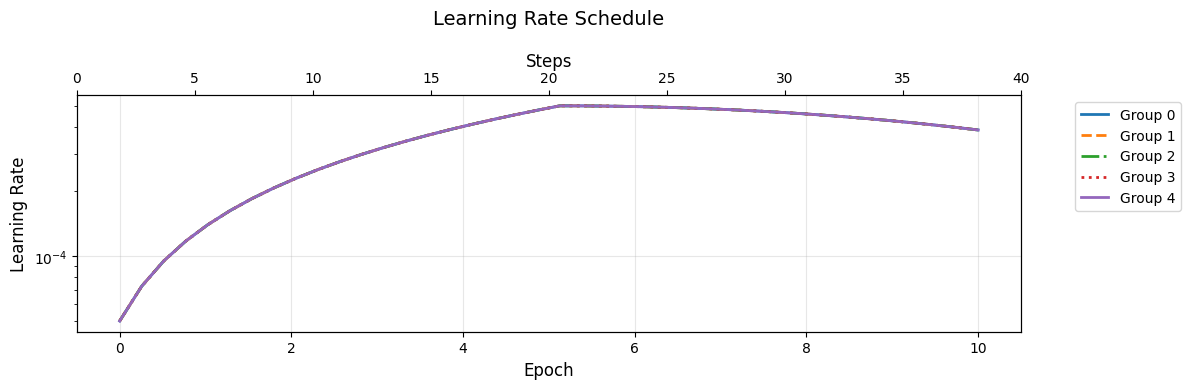

ValidationError: 1 validation error for Settings
x_disable_hardware_metrics
  Extra inputs are not permitted [type=extra_forbidden, input_value=True, input_type=bool]
    For further information visit https://errors.pydantic.dev/2.11/v/extra_forbidden

In [10]:
trainer.optimizer = create_optimizer(
    model=model,
    opt_config=config['optimizer']
)

trainer.scheduler = create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

plot_lr_schedule(
    scheduler=trainer.scheduler,
    num_epochs=config['training']['epochs'], 
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

# Initialize WandB
if trainer.use_wandb:
    wandb.init(
        project=trainer.config['training'].get('wandb_project', 'time-series-forecasting'),
        config=trainer.config,
        name=trainer.run_name,
        settings=wandb.Settings(
        start_method="thread",             # don't spawn multiprocessing process
        _disable_stats=True,               # avoid launching resource monitor thread
        _disable_hardware_metrics=True     # same — these often cause hangs in Jupyter
        )
    )


# Step 4: TRAIN!!   

In [ ]:
print("here!")
trainer.train(train_loader, val_loader, epochs=100)